In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

%matplotlib inline

# Download MNIST

In [0]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_ds = FashionMNIST(root='data/', train=False, transform=ToTensor())

In [3]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

# Set DataLoader

In [0]:
batch_size = 128

In [0]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, 
                          num_workers=4, pin_memory=True)

val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, 
                        pin_memory=True)

test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, 
                        pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


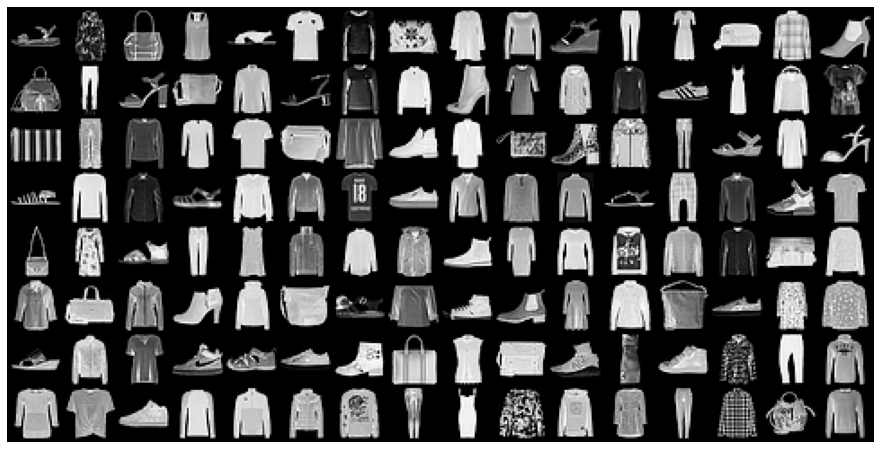

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0))) # move the channel dimension
    # to the end(make_grid applies it to each image passed)
    break

# Model

In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [0]:
class FashionMnistModel(nn.Module):
    
    def __init__(self, in_size, out_size):
        super().__init__() 
        self.linear1 = nn.Linear(in_size, 16)
        # hidden layer 2
        self.linear2 = nn.Linear(16, 32)
        # output layer
        self.linear3 = nn.Linear(32, out_size)


    def forward(self, xb):
        # flatten the image
        out = xb.view(xb.size(0), -1)
        
        out = self.linear1(out)
        out = F.relu(out)
        
        out = self.linear2(out)
        out = F.relu(out)

        out = self.linear3(out)
        return out
    
    def train_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {'loss': loss, 'acc': acc.detach()}
    
    def valid_step(self, batch):
        with torch.no_grad():
            inputs, labels = batch 
            out = self(inputs)                 
            loss = F.cross_entropy(out, labels)
            acc = accuracy(out, labels)    
        return {'val_loss': loss, 'val_acc': acc}
        
    def get_metrics_epoch_end(self, outputs, validation=True):
        if validation:
            loss_ = 'val_loss'
            acc_ = 'val_acc'
        else:
            loss_ = 'loss'
            acc_ = 'acc'

        batch_losses = [x[f'{loss_}'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x[f'{acc_}'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {f'{loss_}': epoch_loss.item(), f'{acc_}': epoch_acc.item()}

    def epoch_end(self, epoch, result, num_epochs):
        if (epoch+1) % 5 == 0 or epoch == num_epochs-1:
            print(f"Epoch [{epoch+1}] -> loss: {result['loss']:.4f}, acc: {result['acc']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

```
how cross_entropy in pytorch works
takes the labels, converts them to one hot encoded outputs
https://stackoverflow.com/questions/49390842/cross-entropy-in-pytorch
takes the outputs, applies softmax to it and then calculates the loss.
```

`detach()` detaches the output from the computationnal graph. So no gradient will be backproped along this variable.

`torch.no_grad` says that no operation should build the graph.

In [0]:
input_size = 784
num_classes = 10

In [0]:
model = FashionMnistModel(input_size, out_size=num_classes)

In [11]:
for i in model.parameters ():
    print(i.size())

torch.Size([16, 784])
torch.Size([16])
torch.Size([32, 16])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [12]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print(f"Loss: {loss.item()}")
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.2816524505615234
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0284, -0.1737, -0.1372, -0.2929, -0.0892, -0.0582,  0.0320,  0.2706,
         -0.0989, -0.2427],
        [-0.0802, -0.1658, -0.1763, -0.2251, -0.1157,  0.0166,  0.0928,  0.1507,
          0.0183, -0.1336]])


# Set GPU

In [13]:
torch.cuda.is_available()

True

In [0]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else: 
        return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function that can move data and model to a chosen device.

In [0]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [17]:
 for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move data to the selected device, as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. All we need is an __iter__ method to retrieve batches of data, and an __len__ method to get the number of batches.

In [0]:
class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

We can now wrap our data loaders using `DeviceDataLoader`.

In [0]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

Tensors that have been moved to the GPU's RAM have a `device` property which includes the word cuda. Let's verify this by looking at a batch of data from `valid_dl`.

In [20]:
for xb, yb in val_loader:
    print(f"Xb.device: {xb.device}")
    print(f"yb.device: {yb.device}")
    print(f"yb: {yb}")
    break

Xb.device: cuda:0
yb.device: cuda:0
yb: tensor([0, 6, 8, 5, 9, 6, 3, 7, 6, 4, 3, 6, 7, 2, 1, 3, 1, 5, 4, 2, 3, 0, 2, 6,
        4, 1, 4, 4, 8, 1, 2, 5, 9, 2, 4, 2, 9, 7, 9, 9, 9, 8, 2, 7, 8, 8, 9, 0,
        1, 9, 8, 8, 0, 8, 4, 3, 8, 1, 2, 1, 3, 9, 6, 1, 6, 1, 3, 9, 9, 0, 8, 3,
        3, 0, 6, 4, 2, 9, 7, 3, 7, 3, 8, 4, 3, 9, 6, 6, 8, 0, 7, 8, 1, 2, 2, 3,
        8, 9, 4, 9, 8, 2, 8, 0, 1, 5, 7, 1, 3, 0, 9, 8, 9, 8, 5, 7, 9, 0, 3, 8,
        0, 7, 6, 4, 6, 4, 4, 4, 6, 7, 2, 2, 3, 1, 6, 9, 3, 7, 6, 4, 7, 8, 9, 1,
        2, 3, 9, 7, 4, 9, 8, 1, 1, 4, 5, 4, 6, 0, 7, 9, 0, 6, 8, 4, 3, 0, 9, 0,
        9, 1, 9, 7, 7, 8, 3, 3, 7, 2, 4, 0, 6, 5, 0, 2, 7, 0, 1, 1, 1, 5, 3, 1,
        2, 1, 1, 5, 7, 9, 6, 2, 2, 7, 7, 3, 2, 0, 2, 9, 6, 3, 7, 5, 0, 9, 0, 5,
        9, 6, 5, 8, 0, 3, 7, 2, 4, 9, 1, 6, 2, 7, 5, 9, 7, 4, 1, 4, 8, 9, 0, 1,
        9, 6, 3, 1, 7, 3, 2, 4, 7, 8, 0, 9, 2, 5, 3, 4], device='cuda:0')


# Training the Model

In [0]:
def evaluate(model, val_loader):
    outputs = [model.valid_step(batch) for batch in val_loader]
    return model.get_metrics_epoch_end(outputs, validation=True)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    train_history = []

    for epoch in range(epochs):
        # Training Phase 
        
        for batch in train_loader:
            info = model.train_step(batch)
            loss = info['loss']
            # contains batch loss and acc for training phase
            train_history.append(info)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_result = model.get_metrics_epoch_end(train_history, validation=False)
        val_result = evaluate(model, val_loader)
        result = {**train_result, **val_result}

        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device.

In [22]:
# Model (on GPU)
model = FashionMnistModel(input_size, out_size=num_classes)
to_device(model, device)

FashionMnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [23]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.15810546278953552, 'val_loss': 2.310864210128784}]

In [24]:
history = fit(10, 0.05, model, train_loader, val_loader)

Epoch [5] -> loss: 0.6608, acc: 0.7645, val_loss: 0.4328, val_acc: 0.8469
Epoch [10] -> loss: 0.5394, acc: 0.8078, val_loss: 0.4621, val_acc: 0.8350


In [25]:
history += fit(10, 0.01, model, train_loader, val_loader)

Epoch [5] -> loss: 0.3705, acc: 0.8674, val_loss: 0.3748, val_acc: 0.8642
Epoch [10] -> loss: 0.3668, acc: 0.8689, val_loss: 0.3724, val_acc: 0.8673


Text(0.5, 1.0, 'Accuracy vs. epochs')

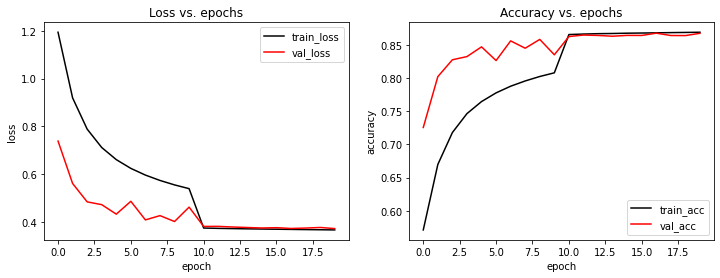

In [26]:
train_losses = [r['loss'] for r in history]
val_losses = [r['val_loss'] for r in history]
train_acc = [r['acc'] for r in history]
val_acc = [r['val_acc'] for r in history]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, c='k', label="train_loss")
plt.plot(val_losses, c='r', label="val_loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, c='k', label="train_acc")
plt.plot(val_acc, c='r', label="val_acc")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. epochs')

# Evaluation

In [30]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 0.8558593988418579, 'val_loss': 0.40285778045654297}

In [0]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


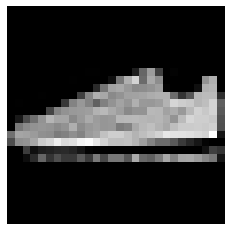

In [31]:
img, label = test_ds[919]
plt.imshow(img[0], cmap='gray')
plt.axis("off")
print('Label:', label, ', Predicted:', predict_image(img.to(device), model))

In [0]:
torch.save(model.state_dict(), 'fashion-mnist-NN.pth')